Denoising Frames: 100%|██████████| 20/20 [00:00<00:00, 1092.01it/s]


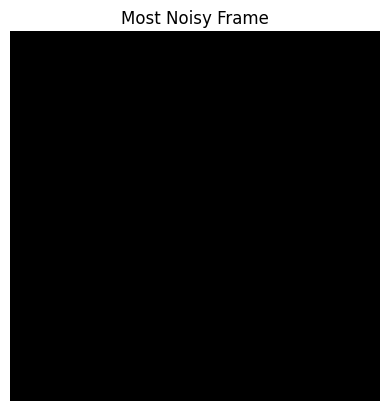

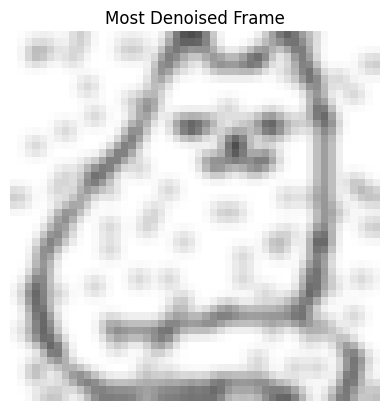

In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to add black and white (salt-and-pepper) noise to an image
def add_black_and_white_noise(image, noise_factor=0.05):
    row, col, ch = image.shape
    # Create a random noise matrix for black and white noise
    noisy_image = np.copy(image)
    # Salt noise (white pixels)
    salt = np.random.rand(row, col) < noise_factor  # Only grayscale noise matrix
    noisy_image[salt] = [255, 255, 255]  # Set salt (white) pixels to 255 in all channels
    # Pepper noise (black pixels)
    pepper = np.random.rand(row, col) < noise_factor  # Only grayscale noise matrix
    noisy_image[pepper] = [0, 0, 0]  # Set pepper (black) pixels to 0 in all channels
    return noisy_image

# Function to denoise an image using GaussianBlur
def denoise_image(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

# Load the image (make sure you replace 'cat.png' with the path to your image)
image = cv2.imread('cat.png')

# Convert the image to RGB (OpenCV loads it as BGR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a list to store noisy images (most noisy first)
noisy_images = []

# Generate noisy images in reverse order (most noisy first)
for i in tqdm(range(20, 0, -1), desc="Generating Noisy Images"):
    noisy_images.append(add_black_and_white_noise(image_rgb, noise_factor=i*0.05))

# Create a list to store the denoised frames for the GIF
frames = []

# Denoise the images progressively and store them as frames
for noisy_image in tqdm(noisy_images, desc="Denoising Frames"):
    denoise_image_step = denoise_image(noisy_image)
    frames.append(Image.fromarray(denoise_image_step))

# Save the animated GIF
frames[0].save('cat_denoise_reversed.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

# Display the first frame (most noisy) for reference
plt.imshow(frames[0])
plt.axis('off')
plt.title("Most Noisy Frame")
plt.show()

# Display the last frame (most denoised) for reference
plt.imshow(frames[-1])
plt.axis('off')
plt.title("Most Denoised Frame")
plt.show()


In [4]:
# Ensure that you've loaded the model weights and set the model to eval mode as shown in your code:
nn_model.load_state_dict(torch.load(f"{save_dir}/context_model_31.pth", map_location=device))
nn_model.eval()

# Assume noisy_image is a tensor representing the noisy cat image (3, height, height)
noisy_image = torch.randn(1, 3, height, height).to(device)  # Replace this with your actual noisy image

# Sample without context or with your desired context (for example, using the same random context):
ctx = F.one_hot(torch.randint(0, 5, (1,)), 5).to(device=device).float()

# Perform the denoising using DDIM
@torch.no_grad()
def denoise_noise_cat_image(noisy_image, context, n_steps=25):
    samples = noisy_image
    intermediate = []
    step_size = timesteps // n_steps

    for i in range(timesteps, 0, -step_size):
        print(f'Denoising timestep {i:3d}', end='\r')

        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # Predict noise
        eps = nn_model(samples, t, c=context)
        
        # Denoise
        samples = denoise_ddim(samples, i, i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

# Call the denoise function
denoised_image, intermediate_images = denoise_noise_cat_image(noisy_image, ctx)

# Visualize the final denoised image (the last image in the sequence)
final_image = denoised_image.squeeze().permute(1, 2, 0).cpu().numpy()
plt.imshow((final_image * 255).astype(np.uint8))  # Assuming the output is in [0, 1] range
plt.show()

# Optionally, you can visualize the intermediate steps as an animation if needed
animation_ddim = plot_sample(intermediate_images, 1, 1, save_dir, "denoise_ani", None, save=False)
HTML(animation_ddim.to_jshtml())


NameError: name 'nn_model' is not defined

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Define UNet model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

# Linear beta schedule function
def linear_beta_schedule(timesteps):
    # A simple linear schedule for beta values between 0.0001 and 0.02
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# Function to load MNIST dataset
def load_mnist(batch_size):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    return dataloader

# Save model function
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Forward diffusion function
def forward_diffusion(x, t, noise_schedule):
    alpha_t = noise_schedule[t]
    sqrt_alpha_cumprod = torch.sqrt(alpha_t).view(-1, 1, 1, 1)  # Reshape to match batch dimensions
    noise = torch.randn_like(x)  # Generate noise with the same shape as x

    noisy_image = sqrt_alpha_cumprod * x + torch.sqrt(1.0 - alpha_t).view(-1, 1, 1, 1) * noise
    return noisy_image, noise

# Training loop
def train_ddpm(model, dataloader, noise_schedule, optimizer, timesteps, epochs):
    criterion = nn.MSELoss()
    model.train()

    for epoch in range(epochs):
        for batch, _ in dataloader:
            batch = batch.to(device)
            t = torch.randint(0, timesteps, (batch.size(0),), device=device)  # Random timesteps
            noisy_images, noise = forward_diffusion(batch, t, noise_schedule)
            
            optimizer.zero_grad()
            predicted_noise = model(noisy_images)  # Predict the noise
            loss = criterion(predicted_noise, noise)  # Calculate MSE loss
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Main function to train and save the model
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparameters
    batch_size = 64
    epochs = 5
    timesteps = 500
    img_size = 28

    # Model and optimizer
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Noise schedule
    noise_schedule = linear_beta_schedule(timesteps).to(device)

    # Load MNIST data
    dataloader = load_mnist(batch_size)

    # Train the model
    train_ddpm(model, dataloader, noise_schedule, optimizer, timesteps, epochs)

    # Save the model after training
    save_model(model, "ddpm_model.pth")


Epoch 1/5, Loss: 0.0058
Epoch 2/5, Loss: 0.0059
Epoch 3/5, Loss: 0.0052
Epoch 4/5, Loss: 0.0045
Epoch 5/5, Loss: 0.0047
Model saved to ddpm_model.pth


Model loaded from ddpm_model.pth


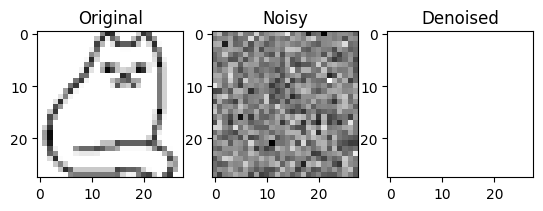

In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define UNet model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

# Linear beta schedule for noise
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# Forward diffusion function
def forward_diffusion(x, t, noise_schedule):
    alpha_t = noise_schedule[t]
    sqrt_alpha_cumprod = torch.sqrt(alpha_t).view(-1, 1, 1, 1)  # Reshape to match batch dimensions
    noise = torch.randn_like(x)  # Generate noise with the same shape as x

    noisy_image = sqrt_alpha_cumprod * x + torch.sqrt(1.0 - alpha_t).view(-1, 1, 1, 1) * noise
    return noisy_image, noise

# Reverse process function
def reverse_process(model, noisy_image, timesteps, noise_schedule):
    # Start from the noisy image and progressively denoise it
    with torch.no_grad():
        x_t = noisy_image
        for t in reversed(range(timesteps)):
            # Predict the noise and subtract it from the noisy image
            predicted_noise = model(x_t)
            alpha_t = noise_schedule[t]
            sqrt_alpha_t = torch.sqrt(alpha_t).view(-1, 1, 1, 1)
            sqrt_1_minus_alpha_t = torch.sqrt(1.0 - alpha_t).view(-1, 1, 1, 1)
            
            # Update x_t using the predicted noise
            x_t = (x_t - sqrt_1_minus_alpha_t * predicted_noise) / sqrt_alpha_t

        return x_t

# Load model function
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Model loaded from {path}")

# Load and process cat.png
def load_cat_image(path, img_size):
    img = Image.open(path).convert("L")
    img = img.resize((img_size, img_size))
    img = np.array(img) / 255.0
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return img

# Main function to load model and use it on cat_3.png
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparameters
    timesteps = 500
    img_size = 28

    # Model setup
    model = UNet().to(device)
    load_model(model, "ddpm_model.pth")

    # Define the noise schedule
    noise_schedule = linear_beta_schedule(timesteps).to(device)

    # Load and noise cat.png
    cat_image = load_cat_image("cat_3.png", img_size).to(device)
    noisy_cat, _ = forward_diffusion(cat_image, timesteps - 1, noise_schedule)

    # Predict denoised image
    denoised_cat = reverse_process(model, noisy_cat, timesteps, noise_schedule)

    # Display results
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cat_image.squeeze().cpu().numpy(), cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Noisy")
    plt.imshow(noisy_cat.squeeze().cpu().detach().numpy(), cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Denoised")
    plt.imshow(denoised_cat.squeeze().cpu().detach().numpy(), cmap="gray")

    plt.show()


In [33]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Improved UNet model with deeper layers
class ImprovedUNet(nn.Module):
    def __init__(self):
        super(ImprovedUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.middle = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
        )

    def forward(self, x):
        x1 = self.encoder[0:2](x)
        x2 = self.encoder[2:4](x1)
        x3 = self.encoder[4:](x2)
        x_middle = self.middle(x3)
        x = self.decoder[0:2](x_middle)
        x = self.decoder[2:](x)
        return x

# Cosine beta schedule for noise
def cosine_beta_schedule(timesteps):
    s = torch.linspace(0, timesteps-1, timesteps)
    alphas_cumprod = torch.cos((s / (timesteps - 1)) * (np.pi / 2))**2
    betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    betas = torch.clip(betas, min=0.0001, max=0.02)  # Clip to reasonable values
    return torch.cat([torch.tensor([0.0001]), betas])

# Forward diffusion function with adjustable noise levels
def forward_diffusion(x, t, noise_schedule, p):
    alpha_t = noise_schedule[t]
    sqrt_alpha_cumprod = torch.sqrt(alpha_t).view(-1, 1, 1, 1)  # Reshape to match batch dimensions
    noise = torch.randn_like(x)  # Generate noise with the same shape as x
    
    # Adjust noise level based on probability p
    noisy_image = sqrt_alpha_cumprod * x + torch.sqrt(1.0 - alpha_t).view(-1, 1, 1, 1) * noise * p
    return noisy_image, noise

# Reverse process function
def reverse_process(model, noisy_image, timesteps, noise_schedule):
    with torch.no_grad():
        x_t = noisy_image
        for t in reversed(range(timesteps)):
            # Predict the noise and subtract it from the noisy image
            predicted_noise = model(x_t)
            alpha_t = noise_schedule[t]
            sqrt_alpha_t = torch.sqrt(alpha_t).view(-1, 1, 1, 1)
            sqrt_1_minus_alpha_t = torch.sqrt(1.0 - alpha_t).view(-1, 1, 1, 1)
            
            # Update x_t using the predicted noise
            x_t = (x_t - sqrt_1_minus_alpha_t * predicted_noise) / sqrt_alpha_t

        return x_t

# Load model function
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Model loaded from {path}")

# Load and process cat.png
def load_cat_image(path, img_size):
    img = Image.open(path).convert("L")
    img = img.resize((img_size, img_size))
    img = np.array(img) / 255.0
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return img

# Main function to load model and use it on cat_3.png
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparameters
    timesteps = 500
    img_size = 28

    # Model setup
    model = ImprovedUNet().to(device)
    load_model(model, "ddpm_model.pth")

    # Define the cosine noise schedule
    noise_schedule = cosine_beta_schedule(timesteps).to(device)

    # Load the original cat image
    cat_image = load_cat_image("cat_3.png", img_size).to(device)

    # Set different noise levels to test
    noise_levels = [0.1, 0.2, 0.3, 0.4]

    # Display results for each noise level
    plt.figure(figsize=(12, 12))
    for i, p in enumerate(noise_levels):
        # Apply forward diffusion with the current noise level
        noisy_cat, _ = forward_diffusion(cat_image, timesteps - 1, noise_schedule, p)

        # Predict denoised image
        denoised_cat = reverse_process(model, noisy_cat, timesteps, noise_schedule)

        # Plot the original, noisy, and denoised images
        plt.subplot(4, 3, 3 * i + 1)
        plt.title(f"Original")
        plt.imshow(cat_image.squeeze().cpu().numpy(), cmap="gray")

        plt.subplot(4, 3, 3 * i + 2)
        plt.title(f"Noisy (p={p})")
        plt.imshow(noisy_cat.squeeze().cpu().detach().numpy(), cmap="gray")

        plt.subplot(4, 3, 3 * i + 3)
        plt.title(f"Denoised (p={p})")
        plt.imshow(denoised_cat.squeeze().cpu().detach().numpy(), cmap="gray")

    plt.tight_layout()
    plt.show()


RuntimeError: Error(s) in loading state_dict for ImprovedUNet:
	Missing key(s) in state_dict: "encoder.4.weight", "encoder.4.bias", "decoder.4.weight", "decoder.4.bias". 
	size mismatch for middle.0.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for middle.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.2.weight: copying a param with shape torch.Size([1, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for decoder.2.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([64]).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
from tqdm import tqdm

# Define UNet model for DDPM
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(1, 64),
            conv_block(64, 128),
            conv_block(128, 256)
        )
        self.middle = conv_block(256, 512)
        self.decoder = nn.Sequential(
            conv_block(512, 256),
            conv_block(256, 128),
            conv_block(128, 64),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        middle = self.middle(encoded)
        decoded = self.decoder(middle)
        return decoded

# Forward and backward diffusion functions
def forward_diffusion(x_0, t, betas):
    noise = torch.randn_like(x_0)
    sqrt_alpha_cumprod = torch.sqrt(1 - betas.cumsum(0))
    sqrt_one_minus_alpha_cumprod = torch.sqrt(betas.cumsum(0))
    return sqrt_alpha_cumprod[t] * x_0 + sqrt_one_minus_alpha_cumprod[t] * noise, noise

def sample_timesteps(n_samples, T):
    return torch.randint(0, T, (n_samples,), device=device)

# Training and generation setup
def train_ddpm(model, dataloader, T, betas, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for x in tqdm(dataloader):
            x = x.to(device)
            t = sample_timesteps(x.size(0), T)

            noisy_x, noise = forward_diffusion(x, t, betas)
            predicted_noise = model(noisy_x)
            
            loss = mse_loss(predicted_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

def generate_images(model, x_shape, T, betas):
    model.eval()
    generated_image = torch.randn(x_shape, device=device)
    sqrt_alpha_cumprod = torch.sqrt(1 - betas.cumsum(0))
    sqrt_one_minus_alpha_cumprod = torch.sqrt(betas.cumsum(0))

    for t in reversed(range(T)):
        pred_noise = model(generated_image)
        generated_image = (generated_image - sqrt_one_minus_alpha_cumprod[t] * pred_noise) / sqrt_alpha_cumprod[t]

    return generated_image

# Initialize model and hyperparameters
T = 1000
betas = torch.linspace(1e-4, 0.02, T)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)

# Load and preprocess `cat.png`
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

image = Image.open("cat.png")
image = transform(image).unsqueeze(0).to(device)

# Add noise to `cat.png`
noisy_image, _ = forward_diffusion(image, T // 2, betas)  # Adding noise at step T/2
save_image(noisy_image, "noisy_cat.png")

# Denoise `cat.png`
def denoise_image(model, noisy_image, T, betas):
    model.eval()
    sqrt_alpha_cumprod = torch.sqrt(1 - betas.cumsum(0))
    sqrt_one_minus_alpha_cumprod = torch.sqrt(betas.cumsum(0))

    for t in reversed(range(T)):
        pred_noise = model(noisy_image)
        noisy_image = (noisy_image - sqrt_one_minus_alpha_cumprod[t] * pred_noise) / sqrt_alpha_cumprod[t]

    return noisy_image

# Denoise the image
restored_image = denoise_image(model, noisy_image, T, betas)
save_image(restored_image, "denoised_cat.png")
